---
kernelspec:
  name: python3
  display_name: Python 3

skip_execution: true
---

# Interactive Visualizion with Open Altimetry & Google Earth Engine

By Philipp Arndt, Chancelor Roberts \
Scripps Institution of Oceanography, University of California San Diego \
Github: [@fliphilipp](https://github.com/fliphilipp), [@chancelorr](https://github.com/chancelorr) \
Contact: ccroberts@ucsd.edu

## Learning Objectives

* Discover some interesting ICESat-2 data by browsing [OpenAltimetry](https://openaltimetry.org/data/icesat2/)
* Get the data into a Jupyter Notebook, plot it and overlay the ground track on a map
* Use [Google Earth Engine](https://earthengine.google.com/) to find the closest-in-time Sentinel-2 image that is cloud-free along ICESat-2's gound track
* Make a plot from ICESat-2 data and contemporaneous imagery in Jupyter/matplotlib
* Bonus Code: Use Google Earth Engine to extract Sentinel-2 data along the ICESat-2 ground track 


## Computing environment

We'll be using the following Python libraries in this notebook:

In [58]:
#%matplotlib widget 
import os
import ee
import geemap
import requests
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
from ipywidgets import Layout
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp

    
The import below is a class that I wrote myself. It helps us read and store data from the OpenAltimetry API.  
If you are interested in how this works, you can find the code in `utils/oa.py`.

In [59]:
import utils.oa as oa
from utils.oa import dataCollector

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Google Earth Engine Authentication and Initialization
GEE requires you to authenticate your access, so if `ee.Initialize()` does not work you first need to run `ee.Authenticate()`. This gives you a link at which you can use your google account that is associated with GEE to get an authorization code. Copy the authorization code into the input field and hit *enter* to complete authentication. 

In [60]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## Downloading data from the OpenAltimetry API

Let's say we have found some data that looks weird to us, and we don't know what's going on.

![image showing OpenAltimetry screenshot](https://raw.githubusercontent.com/fliphilipp/images/main/oa-data.jpg)

### A short explanation of how I got the data:
I went to [openaltimetry.org](https://openaltimetry.org/) and selected **BROWSE ICESAT-2 DATA**. Then I selected **ATL 06** (Land Ice Height) on the top right, and switched the projection🌎 to **Arctic**. Then I selected **August 22, 2021** in the calendar📅 on the bottom left, and toggled the **cloud**☁️ button to show MODIS imagery of that date. I then zoomed in on my region of interest. 

To find out what ICESat-2 has to offer here, I clicked on **SELECT A REGION** on the top left, and drew a rectangle around that mysterious cloud. When right-clicking on that rectangle, I could select **View Elevation profile**. This opened a new tab, and showed me ATL06 and ATL08 elevations. 

It looks like ATL06 can't decide where the surface is, and ATL08 tells me that there's a forest canopy on the Greenland Ice Sheet? To get to the bottom of this, I scrolled all the way down and selected 🛈**Get API URL**. The website confirms that the *"API endpoint was copied to clipboard."* Now I can use this to access the data myself. 

*Note: Instead of trying to find this region yourself, you can access the OpenAltimetry page shown above by going to [this annotation🏷️](http://openaltimetry.org/data/icesat2/?annoId=580&shareKey=d8bebfb8251a69b5b7e2e05df6fd5ca5). Just left-click on the red box and select "View Elevation Profile".*

### Getting the OpenAltimetry info into python
All we need to do is to paste the API URL that we copied from the webpage into a string. 
We also need to specify which beam we would like to look at. The **GT1R** ground track looks funky, so let's look at that one!

In [61]:
# paste the API URL from OpenAltimetry below, and specify the beam you are interested in
oa_api_url = 'https://openaltimetry.earthdatacloud.nasa.gov/data/icesat2/elevation?minx=-25.4835556641541&miny=76.44321462688005&maxx=-21.976284749133928&maxy=77.33633089376721&zoom_level=5&beams=1,2,3,4,5,6&tracks=1236&date=2024-09-06&product=ATL06&mapType=arctic'
gtx = 'gt1r'

We can now initialize a `dataCollector` object, using the copy-pasted OpenAltimetry API URL, and the beam we would like to look at. \
*(Again, I defined this class in `utils/oa.py` to do some work for us in the background.)*

In [62]:
is2data = dataCollector(oaurl=oa_api_url, beam=gtx, verbose=True)

OpenAltimetry API URL: https://openaltimetry.earthdatacloud.nasa.gov/data/api/icesat2/atlXX?minx=-25.4835556641541&maxx=-21.976284749133928&miny=76.44321462688005&maxy=77.33633089376721&date=2024-09-06&trackId=1236&beamNames=gt1r&client=portal&outputFormat=json
Date: 2024-09-06
Track: 1236
Beam: gt1r
Latitude limits: ['76.44321462688005', '77.33633089376721']
Longitude limits: ['-25.4835556641541', '76.44321462688005']


Alternatively, we could use a date, track number, beam, and lat/lon bounding box as input to the `dataCollector`.

In [63]:
date = '2021-08-22'
rgt = 909
beam = 'gt1r'
latlims = [77.5326, 77.5722]
lonlims = [-23.9891, -23.9503]
is2data = dataCollector(date=date, latlims=latlims, lonlims=lonlims, track=rgt, beam=beam, verbose=True)

OpenAltimetry API URL: https://openaltimetry.earthdatacloud.nasa.gov/data/api/icesat2/atlXX?minx=-23.9891&miny=77.5326&maxx=-23.9503&maxy=77.5722&date=2021-08-22&trackId=909&beamNames=gt1r&client=portal&outputFormat=json
Date: 2021-08-22
Track: 909
Beam: gt1r
Latitude limits: [77.5326, 77.5722]
Longitude limits: [-23.9891, 77.5326]


Note that this also constructs the API url for us.

### Requesting the data from the OpenAltimetry API
Here we use the `requestData()` function of the `dataCollector` class, which is defined in `utils/oa.py`. It downloads all data products that are available on OpenAltimetry based on the inputs with which we initialized our `dataCollector`, and writes them to pandas dataframes.

In [64]:
is2data.requestData(verbose=True)

---> requesting ATL03 data... 6314 data points.
---> requesting ATL06 data... 194 data points.
---> requesting ATL07 data... request failed.
---> requesting ATL08 data... 26 data points.
---> requesting ATL10 data... request failed.
---> requesting ATL12 data... request failed.


The data are now stored as data frames in our `dataCollector` object. To verify this, we can run the cell below.

In [65]:
vars(is2data)

{'url': 'https://openaltimetry.earthdatacloud.nasa.gov/data/api/icesat2/atlXX?minx=-23.9891&miny=77.5326&maxx=-23.9503&maxy=77.5722&date=2021-08-22&trackId=909&beamNames=gt1r&client=portal&outputFormat=json',
 'date': '2021-08-22',
 'track': 909,
 'beam': 'gt1r',
 'latlims': [77.5326, 77.5722],
 'lonlims': [-23.9891, 77.5326],
 'atl03':             lat        lon           h   conf
 0     77.572273 -23.953864  748.409241  Noise
 1     77.572246 -23.953913  847.594727  Noise
 2     77.572247 -23.953895  785.343201  Noise
 3     77.572232 -23.953941  906.424866  Noise
 4     77.572222 -23.953903  739.359497  Noise
 ...         ...        ...         ...    ...
 6309  77.532606 -23.986983  788.247559   High
 6310  77.532600 -23.986988  787.683777   High
 6311  77.532593 -23.986994  788.859985   High
 6312  77.532594 -23.986993  786.800476   High
 6313  77.532594 -23.986993  787.658264   High
 
 [6314 rows x 4 columns],
 'atl06':            lat        lon           h
 0    77.572104 -23.95

## Plotting the ICESat-2 data
Now let's plot this data. Here, we are just creating an empty figure `fig` with axes `ax`.

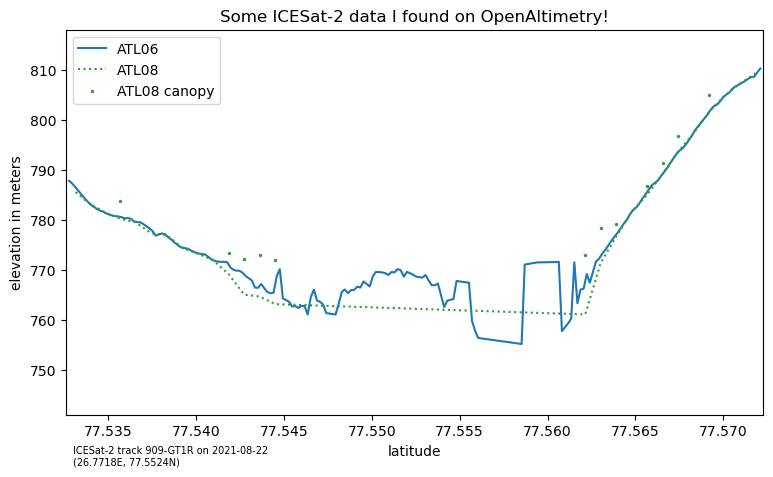

In [66]:
# create the figure and axis
fig, ax = plt.subplots(figsize=[9,5])

# plot the data products
atl06, = ax.plot(is2data.atl06.lat, is2data.atl06.h, c='C0', linestyle='-', label='ATL06')
atl08, = ax.plot(is2data.atl08.lat, is2data.atl08.h, c='C2', linestyle=':', label='ATL08')
if np.sum(~np.isnan(is2data.atl08.canopy))>0:
    atl08canopy = ax.scatter(is2data.atl08.lat, is2data.atl08.h+is2data.atl08.canopy, s=2, c='C2', label='ATL08 canopy')

# add labels, title and legend
ax.set_xlabel('latitude')
ax.set_ylabel('elevation in meters')
ax.set_title('Some ICESat-2 data I found on OpenAltimetry!')
ax.legend(loc='upper left')

# add some text to provide info on what is plotted
info = 'ICESat-2 track {track:d}-{beam:s} on {date:s}\n({lon:.4f}E, {lat:.4f}N)'.format(track=is2data.track, 
                                                                                        beam=is2data.beam.upper(), 
                                                                                        date=is2data.date, 
                                                                                        lon=np.mean(is2data.lonlims), 
                                                                                        lat=np.mean(is2data.latlims))
infotext = ax.text(0.01, -0.08, info,
                   horizontalalignment='left', 
                   verticalalignment='top', 
                   transform=ax.transAxes,
                   fontsize=7,
                   bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))

# set the axis limits
ax.set_xlim((is2data.atl03.lat.min(), is2data.atl03.lat.max()))
ax.set_ylim((741, 818));

Let's add the ATL03 photons to better understand what might be going on here.

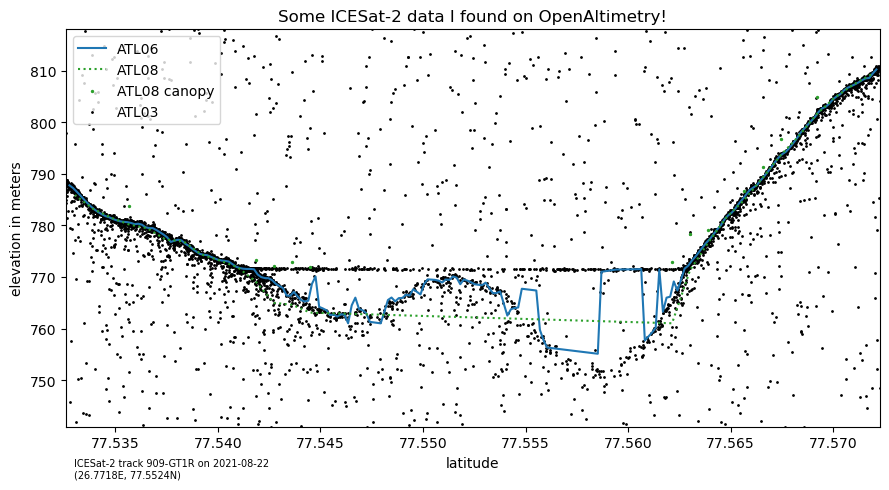

In [67]:
atl03 = ax.scatter(is2data.atl03.lat, is2data.atl03.h, s=1, color='black', label='ATL03', zorder=-1)
ax.legend(loc='upper left')
fig.tight_layout()
display(fig)

### Saving the plot to a file

In [68]:
fig.savefig('my-plot.jpg', dpi=300)

To make plots easier to produce, the `dataCollector` class also has a method to plot the data that we downloaded. 

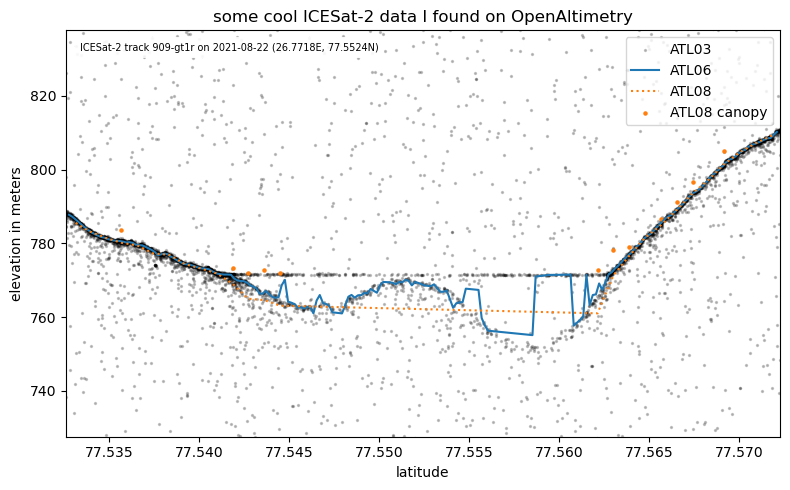

In [69]:
fig = is2data.plotData();
fig

## Ground Track Stats
So far we have only seen the data in elevation vs. latitude space. It's probably good to know what the scale on the x-axis is here in units that we're familiar with. 

In [70]:
def dist_latlon2meters(lat1, lon1, lat2, lon2):
    # returns the distance between two coordinate points - (lon1, lat1) and (lon2, lat2) along the earth's surface in meters.
    R = 6371000
    def deg2rad(deg):
        return deg * (np.pi/180)
    dlat = deg2rad(lat2-lat1)
    dlon = deg2rad(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

lat1, lat2 = is2data.atl08.lat[0], is2data.atl08.lat.iloc[-1]
lon1, lon2 = is2data.atl08.lon[0], is2data.atl08.lon.iloc[-1]

ground_track_length = dist_latlon2meters(lat1, lon1, lat2, lon2)
print('The ground track is about %.1f kilometers long.' % (ground_track_length/1e3))

The ground track is about 4.4 kilometers long.


## Google Earth Engine

Google Earth Engine (GEE) has a large [catalog](https://developers.google.com/earth-engine/datasets) of geospatial raster data, which is ready for analysis in the cloud. It also comes with an online JavaScript code editor.  
<img src="https://raw.githubusercontent.com/fliphilipp/images/main/gee_codeeditor.png" alt="gif showing how to get to the data in OpenAltimetry" width="400px"> 
But since we all seem to be using python, it would be nice to have these capabilities available in our Jupyter comfort zone...

Thankfully, there is a [python API for GEE](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api), which we have imported using `import ee` earlier. It doesn't come with an interactive map, but the python package [geemap](https://geemap.org/) has us covered!

### Show a ground track on a map
We can start working on our map by calling `geemap.Map()`. This just gives us a world map with a standard basemap. 

In [71]:
from ipywidgets import Layout
Map = geemap.Map(layout=Layout(width='70%', max_height='450px'))
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Now we need to add our ICESat-2 gound track to that map. Let's use the lon/lat coordinates of the ATL08 data product for this.  
We also need to specify which **Coordinate Reference System (CRS)** our data is in. The longitude/latitude system that we are all quite familiar with is referenced by [`EPSG:4326`](https://epsg.io/4326). To add the ground track to the map we need to turn it into an [Earth Engine "Feature Collection"](https://developers.google.com/earth-engine/guides/feature_collections).

In [72]:
ground_track_coordinates = list(zip(is2data.atl08.lon, is2data.atl08.lat))
ground_track_projection = 'EPSG:4326' # <-- this specifies that our data longitude/latitude in degrees [https://epsg.io/4326]
gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                      proj=ground_track_projection, 
                                      geodesic=True))
gtx_feature

Now that we have it in the right format, we can add it as a **layer** to the map.

In [73]:
Map.addLayer(gtx_feature, {'color': 'red'}, 'ground track')

According to the cell above this should be a red line. But we still can't see it, because we first need to tell the map where to look for it.  
Let's calculate the center longitude and latitude, and center the map on it. 

In [74]:
center_lon = (lon1 + lon2) / 2
center_lat = (lat1 + lat2) / 2
Map.setCenter(center_lon, center_lat, zoom=7);

So we actually couldn't see it because it was in Greenland.  
Unfortunately the basemap here doesn't give us much more information. Let's add a satellite imagery basemap.
This is a good time to look at the layer control on the top right.

In [75]:
Map.add_basemap('SATELLITE') # <-- this adds a layer called 'Google Satellite'
Map.setCenter(center_lon, center_lat, zoom=7);
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')

...looks like this basemap still doesn't give us any more clues about the nature of this weird ICESat-2 data. Let's dig deeper.

### Query for Sentinel-2 images
Both of these Sentinel-2 satellites take images of most places on our planet at least every week or so. Maybe these images can tell us what was happening here around the same time that ICESat-2 acquired our data?

The imagery scenes live in image collections on Google Earth Engine.  
You can find all collections here: [https://developers.google.com/earth-engine/datasets/catalog/](https://developers.google.com/earth-engine/datasets/catalog/)

The above link tells us we can find some images under `'COPERNICUS/S2_SR_HARMONIZED'`.

In [76]:
collection_name1 = 'COPERNICUS/S2_SR_HARMONIZED'  # Landsat 8 earth engine collection 
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T2

#### Access an image collection
To access the collection, we call `ee.ImageCollection`:

In [77]:
collection = ee.ImageCollection(collection_name1)
collection

Can we find out how many images there are in total?

In [78]:
number_of_scenes = collection.size()
print(number_of_scenes)

ee.Number({
  "functionInvocationValue": {
    "functionName": "Collection.size",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "ImageCollection.load",
          "arguments": {
            "id": {
              "constantValue": "COPERNICUS/S2_SR_HARMONIZED"
            }
          }
        }
      }
    }
  }
})


**Actually, asking for the size of the collection does not do anything!** 🤔

It just tells Earth Engine on the server-side that this variable refers to the size of the collection, which we may need later to do some analysis on the server. As long as this number is not needed, Earth Engine will not go through the trouble actually computing it. 

To force Earth Engine to compute and get any information on the client side (our local machine / Cryocloud), we need to call `.getInfo()`. In this case that would be ```number_of_scenes = collection.size().getInfo()```.

*Because this command would ask Earth Engine to count every single Sentinel-2 file that exists, this command would take a really long time to execute. I will avoid this here and just give you the answer from when I wrote this tutorial.*

In [79]:
# number_of_scenes = collection.size().getInfo()
number_of_scenes = 19323842
print('There are %i number of scenes in the image collection' % number_of_scenes)

There are 19323842 number of scenes in the image collection


#### Filter an image collection by location and time
Who wants to look at almost 20 million pictures? I don't. So let's try to narrow it down.  
Let's start with only images that overlap with the center of our ground track. 

In [80]:
# the point of interest (center of the track) as an Earth Engine Geometry
point_of_interest = ee.Geometry.Point(center_lon, center_lat)

In [81]:
collection = collection.filterBounds(point_of_interest)

In [82]:
print('There are {number:d} images in the spatially filtered collection.'.format(number=collection.size().getInfo()))

There are 4056 images in the spatially filtered collection.


Much better! Now let's only look at images that were taken soon before or after ICESat-2 passed over this spot.

In [83]:
days_buffer_imagery = 6

In [84]:
dateformat = '%Y-%m-%d'
datetime_requested = datetime.strptime(is2data.date, dateformat)
search_start = (datetime_requested - timedelta(days=days_buffer_imagery)).strftime(dateformat)
search_end = (datetime_requested + timedelta(days=days_buffer_imagery)).strftime(dateformat)
print('Search for imagery from {start:s} to {end:s}.'.format(start=search_start, end=search_end))

Search for imagery from 2021-08-16 to 2021-08-28.


In [85]:
collection = collection.filterDate(search_start, search_end)
print('There are {number:d} images in the spatially filtered collection.'.format(number=collection.size().getInfo()))

There are 34 images in the spatially filtered collection.


We can also sort the collection by date (`'system:time_start'`), to order the images by acquisition time.

In [86]:
collection = collection.sort('system:time_start') 

#### Get image collection info
Again, we need to use `.getInfo()` to actually see any information on our end. This is a python dictionary. 

In [87]:
info = collection.getInfo()
type(info)

dict

Let's see what's inside!

In [88]:
info.keys()

dict_keys(['type', 'bands', 'version', 'id', 'properties', 'features'])

`'features'` sounds like it could hold information about the images we are trying to find...

In [89]:
len(info['features'])

34

A list of 34 things! Those are probably the 34 images in the collection. Let's pick the first one and dig deeper!

In [90]:
feature_number = 0
info['features'][0].keys()

dict_keys(['type', 'bands', 'version', 'id', 'properties'])

In [91]:
info['features'][feature_number]['id']

'COPERNICUS/S2_SR_HARMONIZED/20210816T150759_20210816T150915_T27XVG'

Looks like we found a reference to a Sentinel-2 image! Let's look at the `'bands'`.

In [92]:
for band in info['features'][feature_number]['bands']:
    print(band['id'], end=', ')

B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12, AOT, WVP, SCL, TCI_R, TCI_G, TCI_B, MSK_CLDPRB, MSK_SNWPRB, QA10, QA20, QA60, MSK_CLASSI_OPAQUE, MSK_CLASSI_CIRRUS, MSK_CLASSI_SNOW_ICE, 

`'properties'` could be useful too! 

In [93]:
info['features'][0]['properties'].keys()

dict_keys(['DATATAKE_IDENTIFIER', 'AOT_RETRIEVAL_ACCURACY', 'SPACECRAFT_NAME', 'SATURATED_DEFECTIVE_PIXEL_PERCENTAGE', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A', 'CLOUD_SHADOW_PERCENTAGE', 'MEAN_SOLAR_AZIMUTH_ANGLE', 'system:footprint', 'VEGETATION_PERCENTAGE', 'SOLAR_IRRADIANCE_B12', 'SOLAR_IRRADIANCE_B10', 'SENSOR_QUALITY', 'SOLAR_IRRADIANCE_B11', 'GENERATION_TIME', 'SOLAR_IRRADIANCE_B8A', 'FORMAT_CORRECTNESS', 'CLOUD_COVERAGE_ASSESSMENT', 'THIN_CIRRUS_PERCENTAGE', 'system:time_end', 'WATER_VAPOUR_RETRIEVAL_ACCURACY', 'system:time_start', 'DATASTRIP_ID', 'PROCESSING_BASELINE', 'SENSING_ORBIT_NUMBER', 'NODATA_PIXEL_PERCENTAGE', 'SENSING_ORBIT_DIRECTION', 'GENERAL_QUALITY', 'GRANULE_ID', 'REFLECTANCE_CONVERSION_CORRECTION', 'MEDIUM_PROBA_CLOUDS_PERCENTAGE', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8', 'DATATAKE_TYPE', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B9', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B6', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B7', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B4', 'MEAN_INCIDENCE_ZENITH_ANGLE_B1', 'NOT_VEGETATE

That's a lot going on right there! But `'GRANULE_ID'` is probably useful. Let's go through all our features and print the product id.

In [94]:
for feature in info['features']:
    print(feature['properties']['GRANULE_ID'])

L2A_T27XVG_A023217_20210816T150915
L2A_T26XNM_A023217_20210816T150915
L2A_T27XVG_A023231_20210817T143747
L2A_T26XNM_A023231_20210817T143747
L2A_T27XVG_A032140_20210817T152909
L2A_T26XNM_A032140_20210817T152909
L2A_T27XVG_A032154_20210818T145938
L2A_T26XNM_A032154_20210818T145938
L2A_T27XVG_A032168_20210819T142935
L2A_T26XNM_A032168_20210819T142935
L2A_T27XVG_A023260_20210819T151803
L2A_T26XNM_A023260_20210819T151803
L2A_T27XVG_A023274_20210820T144750
L2A_T26XNM_A023274_20210820T144750
L2A_T27XVG_A032197_20210821T150913
L2A_T26XNM_A032197_20210821T150913
L2A_T27XVG_A032211_20210822T143925
L2A_T26XNM_A032211_20210822T143925
L2A_T27XVG_A023303_20210822T152807
L2A_T26XNM_A023303_20210822T152807
L2A_T27XVG_A023317_20210823T145754
L2A_T26XNM_A023317_20210823T145754
L2A_T27XVG_A023331_20210824T142741
L2A_T26XNM_A023331_20210824T142741
L2A_T27XVG_A032240_20210824T151911
L2A_T26XNM_A032240_20210824T151911
L2A_T27XVG_A032254_20210825T144920
L2A_T26XNM_A032254_20210825T144920
L2A_T27XVG_A023360_2

### Add a Sentinel-2 image to the map
The visible bands in Sentinel-2 are `'B2'`:blue, `'B3'`:green, `'B4'`:red.  
So to show a "true color" RGB composite image on the map, we need to select these bands in the R-G-B order: 

In [95]:
myImage = collection.first()
myImage_RGB = myImage.select('B4', 'B3', 'B2')
vis_params = {'min': 0.0, 'max': 10000, 'opacity': 1.0, 'gamma': 1.5}
Map.addLayer(myImage_RGB, vis_params, name='my image')
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')
Map

Map(center=[np.float64(77.55243682861328), np.float64(-23.970436096191406)], controls=(WidgetControl(options=[…

This seems to have worked. But there's clouds everywhere.

### Calculate the along-track cloud probability
We need a better approach to get anywhere here. To do this, we use not only the [Sentinel-2 Surface Reflectance image collection](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED), but also merge it with the [Sentinel-2 cloud probability collection](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_CLOUD_PROBABILITY), which can be accessed under `COPERNICUS/S2_CLOUD_PROBABILITY`.  

Let's specify a function that adds the cloud probability band to each Sentinel-2 image and calcultes the mean cloud probability in the neighborhood of the ICESat-2 ground track, then map this function over our location/date filtered collection.

In [96]:
def get_sentinel2_cloud_collection(is2data, days_buffer=6, gt_buffer=100):
    
    # create the area of interest for cloud likelihood assessment
    ground_track_coordinates = list(zip(is2data.atl08.lon, is2data.atl08.lat))
    ground_track_projection = 'EPSG:4326' # our data is lon/lat in degrees [https://epsg.io/4326]
    gtx_feature = ee.Geometry.LineString(coords=ground_track_coordinates,
                                     proj=ground_track_projection,
                                     geodesic=True)
    area_of_interest = gtx_feature.buffer(gt_buffer)
    
    datetime_requested = datetime.strptime(is2data.date, '%Y-%m-%d')
    start_date = (datetime_requested - timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%S')
    end_date = (datetime_requested + timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%S')
    print('Search for imagery from {start:s} to {end:s}.'.format(start=start_date, end=end_date))
    
    # Import and filter S2 SR HARMONIZED
    s2_sr_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Import and filter s2cloudless.
    s2_cloudless_collection = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    cloud_collection = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_collection, 'secondary': s2_cloudless_collection,
        'condition': ee.Filter.equals(**{'leftField': 'system:index','rightField': 'system:index'})}))

    cloud_collection = cloud_collection.map(lambda img: img.addBands(ee.Image(img.get('s2cloudless')).select('probability')))
    
    def set_is2_cloudiness(img, aoi=area_of_interest):
        cloudprob = img.select(['probability']).reduceRegion(reducer=ee.Reducer.mean(), 
                                                             geometry=aoi, 
                                                             bestEffort=True, 
                                                             maxPixels=1e6)
        return img.set('ground_track_cloud_prob', cloudprob.get('probability'))
    
    return cloud_collection.map(set_is2_cloudiness)

Get this collection for our ICESat-2 data, and print all the granule IDs and associated cloudiness over the ground track. 

In [97]:
collection = get_sentinel2_cloud_collection(is2data)
info = collection.getInfo()
for feature in info['features']:
    print('%s --> along-track cloud probability: %5.1f %%' % (feature['properties']['GRANULE_ID'],
                                                              feature['properties']['ground_track_cloud_prob']))

Search for imagery from 2021-08-16T00:00:00 to 2021-08-28T00:00:00.
L2A_T26XNM_A023217_20210816T150915 --> along-track cloud probability:  89.7 %
L2A_T27XVG_A023217_20210816T150915 --> along-track cloud probability:  89.7 %
L2A_T26XNM_A023231_20210817T143747 --> along-track cloud probability:   4.5 %
L2A_T27XVG_A023231_20210817T143747 --> along-track cloud probability:   4.6 %
L2A_T26XNM_A032140_20210817T152909 --> along-track cloud probability:  12.1 %
L2A_T27XVG_A032140_20210817T152909 --> along-track cloud probability:  12.1 %
L2A_T26XNM_A032154_20210818T145938 --> along-track cloud probability:  10.3 %
L2A_T27XVG_A032154_20210818T145938 --> along-track cloud probability:  10.1 %
L2A_T26XNM_A032168_20210819T142935 --> along-track cloud probability:  12.9 %
L2A_T27XVG_A032168_20210819T142935 --> along-track cloud probability:  12.8 %
L2A_T26XNM_A023260_20210819T151803 --> along-track cloud probability:   9.8 %
L2A_T27XVG_A023260_20210819T151803 --> along-track cloud probability:   9.

### Filter cloudy images
We specify a certain cloud probability threshold, and then only keep the images that fall below it. Here we are choosing a quite aggressive value of maximum 5% cloud probability...

In [98]:
# filter by maximum allowable cloud probability (in percent)
MAX_CLOUD_PROB_ALONG_TRACK = 5
cloudfree_collection = collection.filter(ee.Filter.lt('ground_track_cloud_prob', MAX_CLOUD_PROB_ALONG_TRACK))
print('There are %i cloud-free scenes.' % cloudfree_collection.size().getInfo())

There are 4 cloud-free scenes.


### Sort the collection by time difference from the ICESat-2 overpass
Using the image property `'system:time_start'` we can calculate the time difference from the ICESat-2 overpass and set it as a property. This allows us to sort the collection by it and to make sure that the first image in the collection is the closest-in-time to ICESat-2 image that is also cloud-free. 

In [99]:
# get the time difference between ICESat-2 overpass and Sentinel-2 acquisitions, set as image property
is2time = is2data.date + 'T12:00:00'
def set_time_difference(img, is2time=is2time):
    timediff = ee.Date(is2time).difference(img.get('system:time_start'), 'second').abs()
    return img.set('timediff', timediff)
cloudfree_collection = cloudfree_collection.map(set_time_difference).sort('timediff')

Print some stats for the final collection to make sure everything looks alright.

In [100]:
info = cloudfree_collection.getInfo()
for feature in info['features']:
    s2datetime = datetime.fromtimestamp(feature['properties']['system:time_start']/1e3)
    is2datetime = datetime.strptime(is2time, '%Y-%m-%dT%H:%M:%S')
    timediff = s2datetime - is2datetime
    timediff -= timedelta(microseconds=timediff.microseconds)
    diffsign = 'before' if timediff < timedelta(0) else 'after'
    print('%s --> along-track cloud probability: %5.1f %%, %s %7s ICESat-2' % (feature['properties']['GRANULE_ID'],
              feature['properties']['ground_track_cloud_prob'],np.abs(timediff), diffsign))

L2A_T26XNM_A023274_20210820T144750 --> along-track cloud probability:   1.3 %, 2 days, 4:09:34  before ICESat-2
L2A_T27XVG_A023274_20210820T144750 --> along-track cloud probability:   1.3 %, 2 days, 4:09:38  before ICESat-2
L2A_T26XNM_A023231_20210817T143747 --> along-track cloud probability:   4.5 %, 5 days, 4:19:32  before ICESat-2
L2A_T27XVG_A023231_20210817T143747 --> along-track cloud probability:   4.6 %, 5 days, 4:19:36  before ICESat-2


### Show the final image and ground track on the map

In [101]:
first_image_rgb = cloudfree_collection.first().select('B4', 'B3', 'B2')
Map = geemap.Map(layout=Layout(width='70%', max_height='450px'))
Map.add_basemap('SATELLITE')
Map.addLayer(first_image_rgb, vis_params, name='my image')
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')
Map.centerObject(gtx_feature, zoom=12)
Map

Map(center=[77.55243721126286, -23.970458522024117], controls=(WidgetControl(options=['position', 'transparent…

### Download images from Earth Engine

We can use [`.getDownloadUrl()`](https://developers.google.com/earth-engine/apidocs/ee-image-getdownloadurl) on an Earth Engine image.  

It asks for a scale, which is just the pixel size in meters (10 m for Sentinel-2 visible bands). It also asks for the region we would like to export; here we use a [`.buffer`](https://developers.google.com/earth-engine/apidocs/ee-geometry-buffer) around the center.

*(Note: This function can only be effectively used for small download jobs because there is a request size limit. Here, we only download a small region around the ground track, and convert the image to an 8-bit RGB composite to keep file size low. For larger jobs you should use [`Export.image.toDrive`](https://developers.google.com/earth-engine/apidocs/export-image-todrive))*

In [102]:
# create a region around the ground track over which to download data
point_of_interest = ee.Geometry.Point(center_lon, center_lat)
buffer_around_center_meters = ground_track_length*0.52
region_of_interest = point_of_interest.buffer(buffer_around_center_meters)

# make the image 8-bit RGB
s2rgb = first_image_rgb.unitScale(ee.Number(0), ee.Number(10000)).clamp(0.0, 1.0).multiply(255.0).uint8()

# get the download URL
downloadURL = s2rgb.getDownloadUrl({'name': 'mySatelliteImage',
                                          'crs': s2rgb.projection().crs(),
                                          'scale': 10,
                                          'region': region_of_interest,
                                          'filePerBand': False,
                                          'format': 'GEO_TIFF'})
downloadURL

'https://earthengine.googleapis.com/v1/projects/995399951136/thumbnails/379edef29d5780364f154c11d047e8a4-1625732f667ec3b9893fb8a4a8c034ef:getPixels'

We can save the content of the download URL with the [`requests`](https://docs.python-requests.org/en/latest/) library. 

In [103]:
response = requests.get(downloadURL)
filename = 'my-satellite-image.tif'
with open(filename, 'wb') as f:
    f.write(response.content)
print('Downloaded %s' % filename)

Downloaded my-satellite-image.tif


### Open a GeoTIFF in rasterio
Now that we have saved the file, we can open it locally with the [`rasterio`](https://rasterio.readthedocs.io/en/latest/intro.html) library.

In [104]:
myImage = rio.open(filename)
myImage

<open DatasetReader name='my-satellite-image.tif' mode='r'>

### Plot a GeoTIFF in Matplotlib
Now we can easily plot the image in a matplotlib figure, just using the [`rasterio.plot()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html) module. 

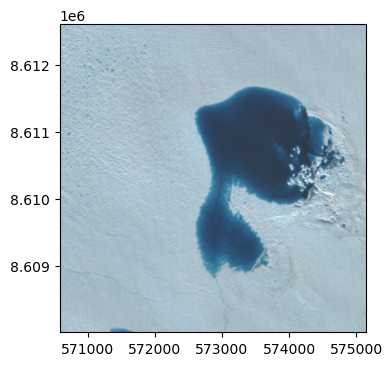

In [105]:
fig, ax = plt.subplots(figsize=[4,4])
rioplot.show(myImage, ax=ax);

### transform the ground track into the image CRS
Because our plot is now in the Antarctic Polar Stereographic Coordrinate Reference System, we need to project the coordinates of the ground track from lon/lat values. The [`rasterio.warp.transform`](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html) function has us covered. From then on, it's just plotting in Matplotlib. 

In [106]:
gtx_x, gtx_y = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=is2data.atl08.lon, ys=is2data.atl08.lat)
ax.plot(gtx_x, gtx_y, color='red', linestyle='-')
ax.axis('off')

(np.float64(570580.0),
 np.float64(575140.0),
 np.float64(8608010.0),
 np.float64(8612600.0))

## Summary

 🎉 Congratulations! You've completed this tutorial and have seen how we can put ICESat-2 photon-level data into context using Google Earth Engine and the OpenAltimetry API. 
 
You can explore a few more use cases for this code (and possible solutions for Exercise 2) in [this notebook](./use_examples.ipynb).

## References

To further explore the topics of this tutorial see the following detailed documentation:

* [The OpenAltimetry API](https://openaltimetry.org/data/swagger-ui/)
* [Google Earth Engine JavaScript and Python Guides](https://developers.google.com/earth-engine/guides)
* [Tutorial on Sentinel-2 cloud masking with s2cloudless](https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless)
* [The geemap package](https://geemap.org/) and [tutorials](https://geemap.org/tutorials/)